# SSY340 Project - Animal Detection Networks for Univeseum
Group 8: Zhuqi Xiao, Yizhe Gu

**Note**：To run this notebook, please follow the setps listed in [YOLOv5 Enviornment](#env) to have its enviornment. 

## Dataset annotation

The very first step of our project is to collect and annotate our dataset, which is very critical step. 

For this project, we went to the museum in person and manually collected 764 images of real scenes, which contains 19 classes of different animals. 

The most popular formats for annotating an object detection datasets are 
+ Pascal VOC, 
+ Micosoft COCO, and
+ YOLO format. 

Since we intend to use transfer learning, YOLO and Faster R-CNN require different formats of annotations, so two different annotation formats have been prepared, VOC and YOLO formats. 

Rearding the labelling tool, we used an open source tool for our job. 

Link to [labelImg](https://github.com/tzutalin/labelImg.git) on github.

Steps to install:
```shell
$ git clone https://github.com/tzutalin/labelImg.git
$ cd labelImg
$ pip3 install pyqt5 lxml
$ make qt5py3
$ python3 labelImg.py
$ # python3 labelImg.py [IMAGE_PATH] [PRE-DEFINED CLASS FILE]
```

To initiate a label, type `w`, and draw the intended label. Then, type ctrl (or command) `S` to save the label. Type `d` to go to the next image (and `a` to go back an image).

### YOLO format of labeling
Export your labels to YOLO format, with one `*.txt` file per image (if no objects in image, no `*.txt` file is required). The `*.txt` file specifications are:

+ One row per object
+ Each row is `class x_center y_center width height` format.
+ Box coordinates must be in **normalized xywh** format (from 0 - 1). If your boxes are in pixels, divide `x_center` and `width` by image width, and `y_center` and `height` by image height.
+ Class numbers are zero-indexed (start from 0).

### Create data.yaml
This *yaml* file is needed when you want to train a network or want to test your trained network. It provides your dataset info to the training or testing script. 

The file format is shown as below:
```yaml
# dataset.yaml file format
# File hierarchy
#   parent
#   ├── yolov5
#   ├── datasets
#       ├── train
#           ├── images
#           └── labels
#       ├── val
#           ├── images
#           └── labels
#       ├── test
#           ├── images
#           └── labels
#       └── data.yaml


# Train/val/test sets as 
# 1) dir: path/to/imgs, 
# 2) file: path/to/imgs.txt, or 
# 3) list: [path/to/imgs1, path/to/imgs2, ..]

path: ../datasets/data  # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')
test: images/test

# Classes
nc: 19  # number of classes
names: ['Arapaima', 'Blue Fish', 'Clownfish', 'Common Dragonet', 'Emerald Toucanet', 'Goldbelly Damsel', 'Indian Surgeonfish', 'Lemon Damsel', 'Orange Revabborre', 'Picked Dogfish', 'Pied Tamarin', 'Red Ibis', 'Silver Moony', 'Star Fish', 'Stingray', 'Sunbittern', 'Thornback Ray', 'Toco Toucan', 'Yellowfin Surgeonfish'] # class labels
```

### Labeling Best Practices ([From web](https://blog.roboflow.com/labelimg/#:~:text=Labeling%20Best%20Practices))
When labeling images, there are a few tips to bear in mind. Note that these tips are generally true, but can alter based on the context of your problem.

+ Label around the entirety of an object. It is best to include a little bit of non-object buffer than it is to exclude a portion of the object with a rectangular label. So, aim to have boxes that tightly mirror the objects you want to label, but do not cut off part of the objects. Your model will understand edges far better this way.
+ For occluded objects, label them entirely. If an object is out of view due to another object being in front of it, label the object out of view as if you could see its entirety. Your model will begin to understand the true bounds of objects this way.
+ For objects partially out of frame, generally label them. This tip especially depends on your problem, but in general, even a partial object is still an object to be labeled.


## YOLOv5 Enviornment<div id="env"></div>
[YOLOv5 Link](https://github.com/ultralytics/yolov5)

YOLOv5 is an open-source project that consists of a familyof  object  detection  models. In the official repository of Yolov5 on Github, there are a total of 4 versions of the object detection networks, namely `Yolov5s`, `Yolov5m`, `Yolov5l`, and `Yolov5x`, which  represents different sizes of YOLOv5. Besides, training and testing codes are provided. 

Followings are for preparing an enviornment for running the code and assuminig you are using a conda enviornment. 

+ Create a new virtual conda environment
```sh
$ conda create --name yolov5 # create a new virtual env
$ conda activate yolov5 # activate the new created env
$ conda install pip # install pip for later use
```

+ Get pre-trained YOLOv5 model
```sh
$ git clone https://github.com/ultralytics/yolov5  # clone repo
$ cd yolov5
$ pip install -r requirements.txt  # install required packages
```

Now everything should have been prepared and good to go on. 

## Transfer Learning

Since we only have a small dataset, in order to obtain a good model in time, the transfer learning method is adopted. We separately train on pre-trained YOLOv5 model and Faster RCNN model. (In this notebook, only YOLO part is included)

Since the model will be potentially deployed on mobile phones, smaller models are preferred. Therefore, the smallest YOLOv5 architecture, **YOLOv5s**, is then selected to be trained on. 

In [1]:
# # Enviornment check
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.10.0+cu102 (Tesla K80)


In [2]:
# Dataset check
import yaml
with open("./data/" + "/data.yaml", 'r') as stream:
    dataset_info = yaml.safe_load(stream)
num_classes = dataset_info['nc']
print("There are in total {} classes of animals\n{}".format(num_classes,\
                                                        dataset_info['names']))

There are in total 19 classes of animals
['Arapaima', 'Blue Fish', 'Clownfish', 'Common Dragonet', 'Emerald Toucanet', 'Goldbelly Damsel', 'Indian Surgeonfish', 'Lemon Damsel', 'Orange Revabborre', 'Picked Dogfish', 'Pied Tamarin', 'Red Ibis', 'Silver Moony', 'Star Fish', 'Stingray', 'Sunbittern', 'Thornback Ray', 'Toco Toucan', 'Yellowfin Surgeonfish']


### Define Model Configuration and Architecture

Next we will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer. Running the flowing two cells will create a file in `./yolov5/mdoels` named `custom_yolov5s.yaml`, which contains the custom architecture for our project. In this configuration file, we basically use the same architecture with `yolov5s`, but with a smaller number of output classes. 

In [3]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [4]:
%%writetemplate ./yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

### Train Custom YOLOv5 Detector
With our `data.yaml` and `custom_yolov5s.yaml` files ready to go we are ready to train!

Here, we are able to pass a number of arguments:

+ `img`: define input image size
+ `batch`: determine batch size
+ `epochs`: define the number of training epochs. (Note: often, 3000+ are common here!)
+ `data`: set the path to our yaml file
+ `cfg`: specify our model configuration
+ `weights`: specify a custom path to weights
+ `name`: result names
+ `nosave`: only save the final checkpoint
+ `cache`: cache images for faster training

Before get the training started, let's take a look at the training parameters

In [9]:
!cat ./runs/train/yolov5s_results10/hyp.yaml

lr0: 0.01
lrf: 0.1
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.5
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.2
anchor_t: 4.0
fl_gamma: 0.0
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 0.0
translate: 0.1
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0


In [9]:
# train yolov5s on custom data for 100 epochs

%cd ./yolov5/
!python train.py --img 640 --batch 32 --epochs 100 --data ../data/data.yaml --cfg ./models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache

/home/zhuqi/deep-machine-learning/project/SSY340-Project/yolov5
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=../data/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-30-gfee83c1 torch 1.10.0+cu102 CUDA:0 (Tesla K80, 11441.


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     33/99     7.55G   0.04909   0.03529   0.01265         1       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        152        459      0.637      0.638       0.66       0.28

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     34/99     7.55G   0.04887   0.03682   0.01274         5       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        152        459      0.623      0.757      0.711      0.296

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     35/99     7.55G   0.04823    0.0354   0.01254         1       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        152        459      0.637      0.681      0.687      0.283

     Epoch   gpu_mem       box      


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     84/99     7.55G   0.03328   0.02609  0.004611         4       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        152        459      0.876      0.751      0.848      0.481

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     85/99     7.55G   0.03269    0.0265  0.003333         5       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        152        459      0.859      0.797      0.865      0.488

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     86/99     7.55G   0.03362   0.02721  0.004179         5       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        152        459      0.855      0.778      0.842      0.478

     Epoch   gpu_mem       box      

[Errno 2] No such file or directory: './yolov5/'
/Users/zqxiao/Downloads/project/SSY340-Project/yolov5


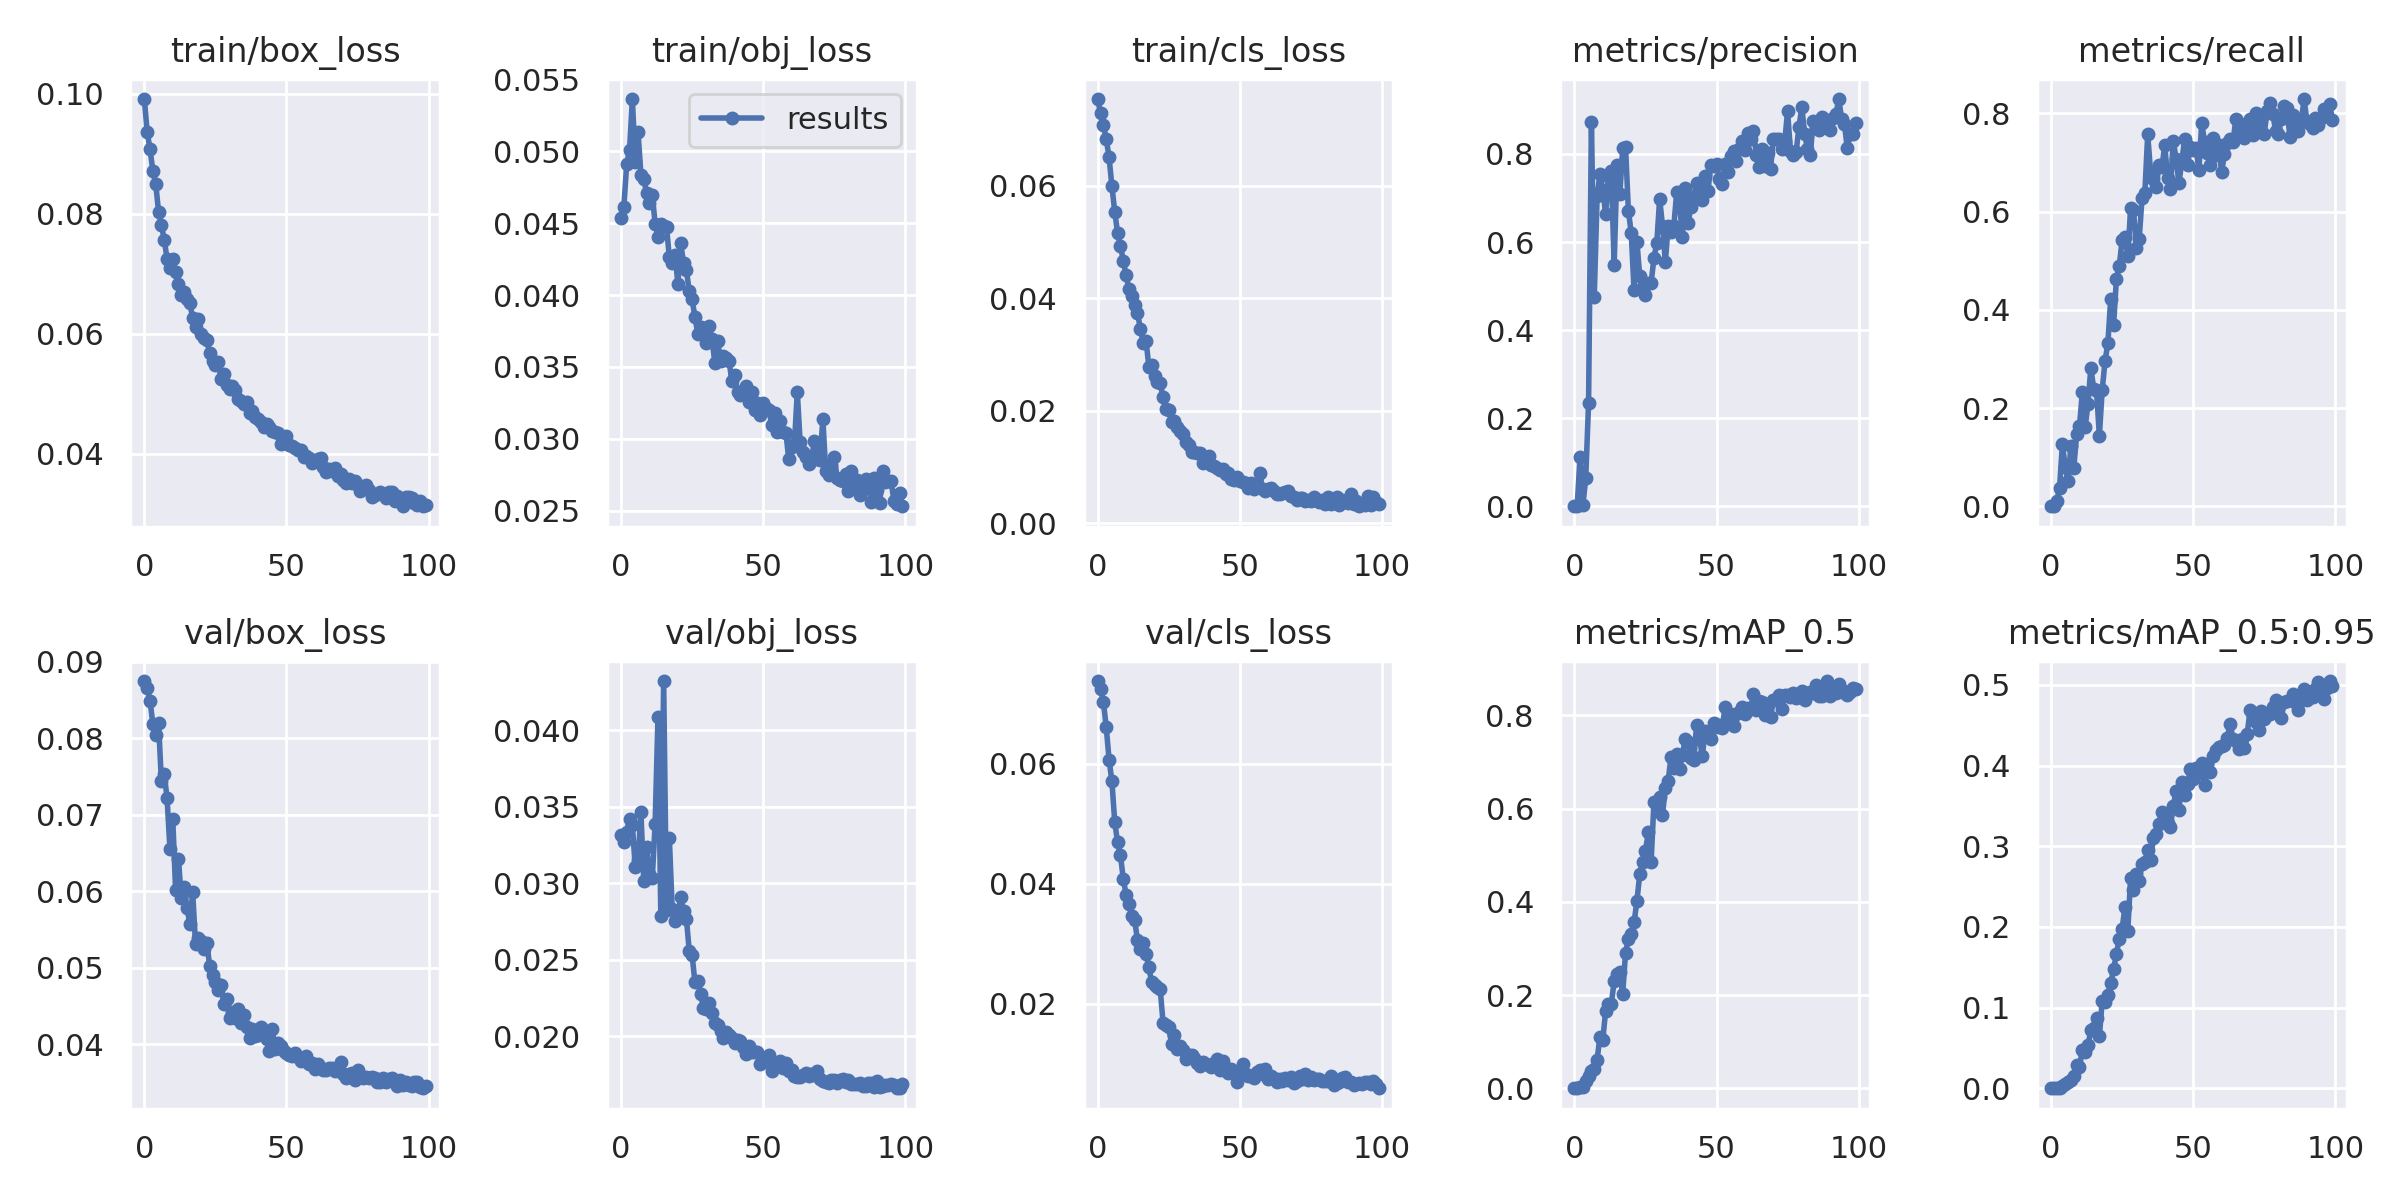

In [8]:
# Check the results
%cd ./yolov5/
from IPython.display import Image, display
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='./runs/train/yolov5s_results10/results.png', width=1000)  # view results

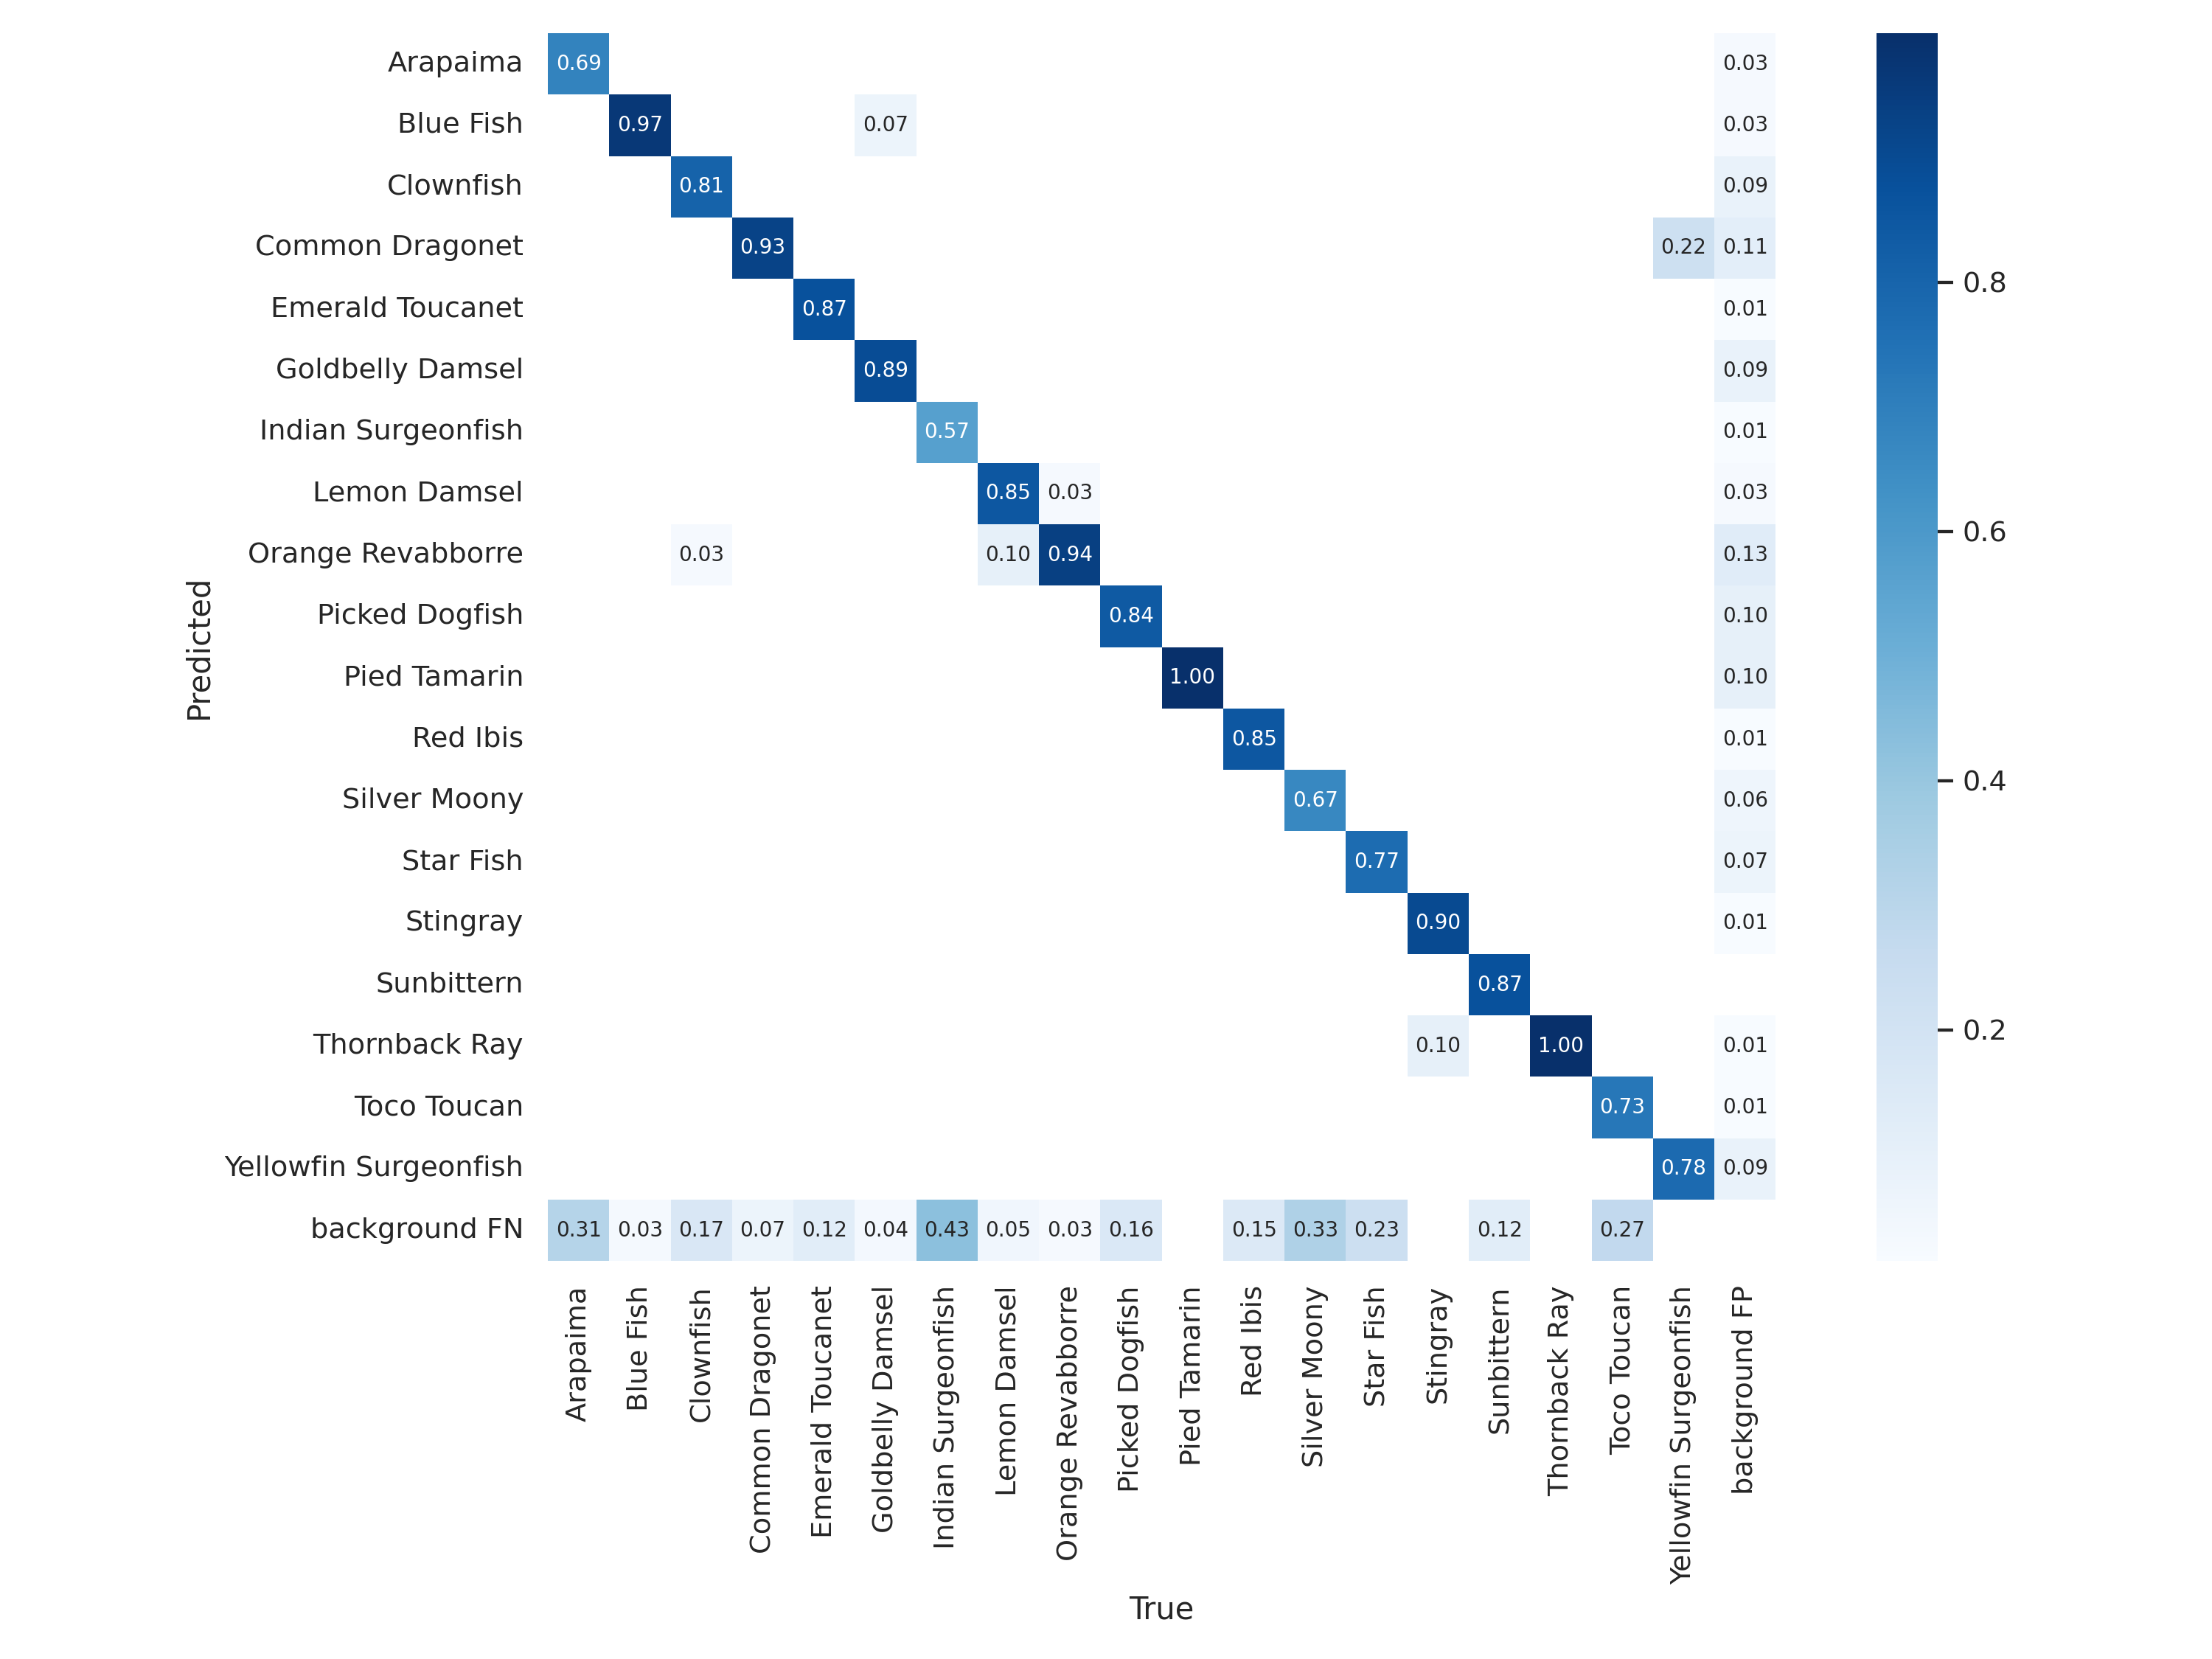

In [7]:
Image(filename='./runs/train/yolov5s_results10/confusion_matrix.png', width=1000)  # view confusion_matrix

In [5]:
# test on test set
!python val.py --data ../data/data.yaml --weights runs/train/yolov5s_results10/weights/best.pt --img 640 --task test

val: data=../data/data.yaml, weights=['runs/train/yolov5s_results10/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False
YOLOv5 🚀 v6.0-30-gfee83c1 torch 1.9.1 CPU

Fusing layers... 
Model Summary: 232 layers, 7295064 parameters, 0 gradients, 16.9 GFLOPs
test: Scanning '/Users/zqxiao/Downloads/project/SSY340-Project/data/test/labels'
test: New cache created: /Users/zqxiao/Downloads/project/SSY340-Project/data/test/labels.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         76        218      0.844      0.741      0.823      0.459
            Arapaima         76         10      0.998        0.2      0.642      0.232
           Blue Fish         76         25      0.894       0.96      0.957      0.613
           

In [6]:
# test on a mp4 video
!python detect.py --source ../data/IMG_0201.mp4 --weights runs/train/yolov5s_results10/weights/best.pt

detect: weights=['runs/train/yolov5s_results10/weights/best.pt'], source=../data/IMG_0201.mp4, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-30-gfee83c1 torch 1.9.1 CPU

Fusing layers... 
Model Summary: 232 layers, 7295064 parameters, 0 gradients, 16.9 GFLOPs
video 1/1 (1/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 1 Lemon Damsel, 6 Orange Revabborres, Done. (0.209s)
video 1/1 (2/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 1 Lemon Damsel, 6 Orange Revabborres

video 1/1 (40/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Lemon Damsel, 4 Orange Revabborres, Done. (0.190s)
video 1/1 (41/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Lemon Damsel, 4 Orange Revabborres, Done. (0.186s)
video 1/1 (42/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Lemon Damsel, 4 Orange Revabborres, Done. (0.185s)
video 1/1 (43/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Lemon Damsel, 5 Orange Revabborres, Done. (0.192s)
video 1/1 (44/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Lemon Damsel, 5 Orange Revabborres, Done. (0.190s)
video 1/1 (45/686) /Users

video 1/1 (82/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 1 Goldbelly Damsel, 1 Lemon Damsel, 7 Orange Revabborres, Done. (0.197s)
video 1/1 (83/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 1 Goldbelly Damsel, 1 Lemon Damsel, 7 Orange Revabborres, Done. (0.185s)
video 1/1 (84/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 1 Goldbelly Damsel, 1 Lemon Damsel, 7 Orange Revabborres, Done. (0.187s)
video 1/1 (85/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 1 Goldbelly Damsel, 1 Lemon Damsel, 7 Orange Revabborres, Done. (0.184s)
video 1/1 (86/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 1 Goldbelly Damsel, 1 Lemon Damsel, 7 Orange Revabborres, Done. (0.184s)
video 1/1 (87/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 3

video 1/1 (122/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 3 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 1 Lemon Damsel, 9 Orange Revabborres, Done. (0.182s)
video 1/1 (123/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 1 Lemon Damsel, 9 Orange Revabborres, Done. (0.185s)
video 1/1 (124/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 9 Orange Revabborres, Done. (0.181s)
video 1/1 (125/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 1 Lemon Damsel, 9 Orange Revabborres, Done. (0.179s)
video 1/1 (126/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 1 Clownfish, 3 Goldbelly Damsels, 1 In

video 1/1 (163/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.187s)
video 1/1 (164/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 3 Clownfishs, 2 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.188s)
video 1/1 (165/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 3 Clownfishs, 2 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.184s)
video 1/1 (166/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.187s)
video 1/1 (167/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.184s)
video 1/1 (168/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue

video 1/1 (207/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.183s)
video 1/1 (208/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.185s)
video 1/1 (209/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.184s)
video 1/1 (210/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 2 Indian Surgeonfishs, 7 Orange Revabborres, Done. (0.199s)
video 1/1 (211/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done

video 1/1 (248/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.193s)
video 1/1 (249/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.191s)
video 1/1 (250/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 8 Orange Revabborres, Done. (0.189s)
video 1/1 (251/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 8 Orange Revabborres, Done. (0.187s)
video 1/1 (252/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 8 Orange Revabborres, Done.

video 1/1 (293/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 8 Orange Revabborres, Done. (0.187s)
video 1/1 (294/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 8 Orange Revabborres, Done. (0.191s)
video 1/1 (295/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 8 Orange Revabborres, Done. (0.181s)
video 1/1 (296/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 8 Orange Revabborres, Done. (0.185s)
video 1/1 (297/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 8 Orange Revabborres, Done. (0.190s)
video 1/1 (298/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue

video 1/1 (339/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.191s)
video 1/1 (340/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.184s)
video 1/1 (341/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.190s)
video 1/1 (342/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.194s)
video 1/1 (343/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.186s)
video 1/1 (344/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue

video 1/1 (384/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 8 Orange Revabborres, Done. (0.191s)
video 1/1 (385/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 8 Orange Revabborres, Done. (0.183s)
video 1/1 (386/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 7 Orange Revabborres, Done. (0.182s)
video 1/1 (387/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.182s)
video 1/1 (388/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.185s)
video 1/1 (389/686) /Users/zqxiao/Downloads/project/SSY3

video 1/1 (428/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 9 Orange Revabborres, Done. (0.195s)
video 1/1 (429/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 2 Indian Surgeonfishs, 8 Orange Revabborres, Done. (0.205s)
video 1/1 (430/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 2 Indian Surgeonfishs, 8 Orange Revabborres, Done. (0.198s)
video 1/1 (431/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 2 Clownfishs, 4 Goldbelly Damsels, 1 Indian Surgeonfish, 1 Lemon Damsel, 8 Orange Revabborres, Done. (0.205s)
video 1/1 (432/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 1 Blue Fish, 2 Clownfishs, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 1 Lemon Da

video 1/1 (467/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Goldbelly Damsels, 2 Indian Surgeonfishs, 2 Lemon Damsels, 9 Orange Revabborres, Done. (0.180s)
video 1/1 (468/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 3 Goldbelly Damsels, 2 Indian Surgeonfishs, 2 Lemon Damsels, 9 Orange Revabborres, Done. (0.190s)
video 1/1 (469/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 3 Goldbelly Damsels, 2 Indian Surgeonfishs, 2 Lemon Damsels, 10 Orange Revabborres, Done. (0.188s)
video 1/1 (470/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 3 Goldbelly Damsels, 2 Indian Surgeonfishs, 2 Lemon Damsels, 9 Orange Revabborres, Done. (0.178s)
video 1/1 (471/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 5 Goldbelly Damsels, 2 Lemon Damsels, 8 Orange Revabb

video 1/1 (510/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 3 Clownfishs, 2 Goldbelly Damsels, 3 Lemon Damsels, 7 Orange Revabborres, Done. (0.188s)
video 1/1 (511/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 3 Clownfishs, 2 Goldbelly Damsels, 3 Lemon Damsels, 7 Orange Revabborres, Done. (0.184s)
video 1/1 (512/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 3 Goldbelly Damsels, 3 Lemon Damsels, 7 Orange Revabborres, Done. (0.182s)
video 1/1 (513/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 4 Lemon Damsels, 7 Orange Revabborres, Done. (0.183s)
video 1/1 (514/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 2 Goldbelly Damsels, 4 Lemon Damsels, 7 Orange Revabborres, Done. (0.182s)
video 1/1 (515/

video 1/1 (553/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 4 Goldbelly Damsels, 1 Lemon Damsel, 6 Orange Revabborres, Done. (0.192s)
video 1/1 (554/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 4 Goldbelly Damsels, 2 Lemon Damsels, 7 Orange Revabborres, Done. (0.195s)
video 1/1 (555/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 4 Goldbelly Damsels, 1 Lemon Damsel, 6 Orange Revabborres, Done. (0.184s)
video 1/1 (556/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 1 Clownfish, 4 Goldbelly Damsels, 1 Lemon Damsel, 6 Orange Revabborres, Done. (0.186s)
video 1/1 (557/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 2 Clownfishs, 4 Goldbelly Damsels, 1 Lemon Damsel, 6 Orange Revabborres, Done. (0.187s)
video 1/1 (558/686) /Us

video 1/1 (596/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 4 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 2 Lemon Damsels, 7 Orange Revabborres, Done. (0.180s)
video 1/1 (597/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 2 Lemon Damsels, 9 Orange Revabborres, Done. (0.184s)
video 1/1 (598/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 1 Lemon Damsel, 8 Orange Revabborres, Done. (0.186s)
video 1/1 (599/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 3 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 1 Lemon Damsel, 8 Orange Revabborres, Done. (0.184s)
video 1/1 (600/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 9 Orange Revabborres, Done. (0.189s)
video 1/1 (601/686) /Users/zqxiao/Downl

video 1/1 (640/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 1 Blue Fish, 1 Clownfish, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 8 Orange Revabborres, Done. (0.210s)
video 1/1 (641/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 1 Blue Fish, 1 Clownfish, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 8 Orange Revabborres, Done. (0.213s)
video 1/1 (642/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 1 Blue Fish, 1 Clownfish, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 8 Orange Revabborres, Done. (0.211s)
video 1/1 (643/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 8 Orange Revabborres, Done. (0.211s)
video 1/1 (644/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 8 Orange Revabborres, Done. (0.210s

video 1/1 (681/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.183s)
video 1/1 (682/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.185s)
video 1/1 (683/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 2 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.183s)
video 1/1 (684/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 7 Orange Revabborres, Done. (0.184s)
video 1/1 (685/686) /Users/zqxiao/Downloads/project/SSY340-Project/data/IMG_0201.mp4: 384x640 2 Blue Fishs, 1 Clownfish, 3 Goldbelly Damsels, 1 Indian Surgeonfish, 6 Orange Revabborres, Done. (0.1

On my Mac, it can only reaches around 5.4 FPS to detect on a video. In a GPU enviornment (GeForce RTX 2060 SUPER), it can reach 200FPS, which is extremely fast. 

A few more rounds of tunning should proceed, with a lower learning rate and probably freeze the backbone part are prefered. 